In [1]:
# Import Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import OS for Large Imports

import os

# Import SKLearn for Machine Learning

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, GroupKFold, cross_val_predict

# Import XGBoost for Machine Learning

import xgboost as xgb

In [2]:
# Competition Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# External Data
census = pd.read_csv('census_starter.csv')
population = pd.read_csv('current population survey\dec22pub.csv')





### Load Current Population Survey

converted to markdown while doing normal eda

survey = pd.DataFrame()

for file in os.listdir('current population survey'):
    if file.endswith('.csv'):
        df = pd.read_csv('current population survey/' + file)
        survey = pd.concat([survey, df])
        
survey.head()

### Dataset Choice

I chose this dataset because I wanted to explore it as EDA for the Kaggle competition and create a model that can be generalized to the private leaderboard. There is also the factor of doing it to learn; mainly, my goal is to understand offline cross-validation schemes for time-series models and improve my exploratory skills. The evaluation metric is Symmetric mean absolute percentage error; under-forecasts are given a more significant penalty than over-forecasting. The competition's goal is to predict microbusiness density which is the microbusiness per 100 people over 18 in a given county. The definition of micro businesses is a business that employs fewer than ten people.


### Dataset Question

What information is necessary to create a model that can accurately forecast the microbusiness density of a given county 4-5 months out? Finding specific information that will allow me to create a model, detect outliers, generate a validation scheme, and build a model.

I wanted to explore the relationship between microbusiness density growth in specific counties in the United States to see if there was a fundamental change in how business is done in the United States. Another thing I wanted to explore was utilizing other datasets that contain key indicators like the unemployment rate, population survey, and government policy changes. 

Consulting previous information related to the dataset and goals for the model was an important step to consider. Some information I found while reading before actually beginning the problem will help me focus on goals, create evaluation metrics, and gain the necessary insight to implement forecasting.

https://www.godaddy.com/ventureforward/wp-content/uploads/2022/09/UCLA-Anderson-Forecast_Microbusiness-Activity-Index-Q2-Update_2022Q2.pdf

https://medium.com/plotly/what-is-a-fips-code-county-level-charts-in-python-4eff383a4cf6

### Model Questions

Knowledge of microbusiness density growth in the United States is critical, but the number of factors and non-linearity which may occur in areas with low population or other outlier indicators would be important in developing an accurate model.

Some things that have already come up during EDA are noticeable changes in spikes related to the idea of domain investors. This occurs because GoDaddy gets information on micro businesses through the registered domains. The effects can be seen when the rate of change from typical yearly norms exceeds 100 - 1000%, which would need to be accounted for within the model.

The validation scheme for the model was changed for a rolling-time series validation for counties and creating linear regression models on the specific county. The specific scheme had to match up with the competition's private lb, which meant that the model was trained on a rolling-time series of 24 months and then validated three months out.

Example: 

Train on August 2019 - July 2021, Validate on August 2021 - October 2021, Increment by three months and repeat until the last three months on the training dataset.

Example: 

![title](rolling.png)

![title](local_valimg.png)



### EDA

Current Questions:

Q. Has microbusiness density ever decreased in a county?

    A: Microbusiness density has decreased for 100 counties, with the mean decrease hovering around -1, while the outliers have a decrease of -3+ %. The cfips seem to be clustered, so the region could be a feature in determining microbusiness density.

Q. How much of an effect do domain investors have on microbusiness density?

    A: My current answer is that domain investors could have a large impact on microbusiness density whether or not the population density is small or not

Q. Are there specific regions that had a higher growth rate?

    A: Some counties have an unusually high growth rate which can be attributed to domain investors or other phenomena

Q. What does microbusiness density look like for counties with small populations?

    A: For small regions, microbusiness density should have high variational growth rates due to the population density being small. They were confirmed during EDA, with populations under 50,000 having a significant standard deviation than populations over 50,000.

Q. What features are correlated with microbusiness density aside from regions or population?

    A: The employment rate is correlated with microbusiness density, but there could be other features like the population distribution of the county, education, workers, and internet access, which could be helpful to the model.

Q. Is there any useful data from government datasets that will allow us to create better models?

    A: Population density surveys and employment surveys, or something similar by the census bureau, would help

Q. What exactly does a high rate of change mean between low populations or high population density areas?

    A: Areas of low population density are more sensitive to the rate of change if GoDaddy domains are registered in the area. For areas of high population density are less susceptible to the rate of change but still can be affected if the number of domains registered is disproportionate.

    Example: 
    1 sites / 1 = 1 mb | 100 sites / 100 = 1 mb 

    It would require 1 magnitude higher than the population size to change mb by 10x
    10 sites / 1 = 10 mb | 1000 sites / 100 = 10 mb


Q. How can the model fit or learn to generalize these large rate_of_changes? 

    A: Since most counties experience a small linear growth in microbusinesses, the model will do fine in generalization for a large number of counties. The main worry here is that domain investors will make the linear model highly biased towards the outlier, even if GoDaddy recognizes and removes the impact.

Q. Since GoDaddy uses a two-year time lag to calculate its microbusiness density, how should I account for this in the model?

    A: If there is a difference in growth between the population size since 2020 in external data, the model will predict accurately with the general population, but I consider time-lagging the model to optimize for competition performance.

    Example: microbusiness density in Feb 2022 is calculated using Feb 2020 population

EDA Results:

1. Counties with rapid spikes in microbusiness_density should have their forecast regression continue from before but added onto the spike
*Check the rate of change in microbusiness_density to check for any outliers

2. Areas with low population density could require a different prediction heuristic than the regression
*Check the average rate of change in microbusiness_density to create a heuristic for outliers

3. Model could be ensembled with different regression norms, l1, l2, and elastic net
*Do not consider this until the model for linear regression + heuristic is 

4. During pre-processing or model building, I would have to address the problem of a high rate of changes

5. Due to time-constraint I may not be able to look in-depth into external data and features that would help me feature-engineer helpful information for the model


### Train Features:

row_id = the row identifier with cfips and first day of the month for a county

cfips = unique indentifier for each county

county_name = the name of the county

state_name = the name of the state

first_day_of_month = the first day of the month

microbusiness_density = target variable, microbusinesses per 100 people over the age of 18 in the given county, *two year lag in population figure used to calculate microbusiness density

active = the active domains or microbusinesses within a certain county

In [3]:
# Basic Data Cleaning / Analysis on Competition Data

train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [5]:
train['county'].unique().shape

(1871,)

Conventional graphing may not work here due to the large number of unique counties, data transformation will be done before the graphing to identify specific counties.

Since they are all sorted by their cfips and months, I am able to take the difference from the row before in order to calculate the difference.

----------------------------------------------------------------
One error that I made during this is that there could counties with the same names in different states, so I switched to using cfips

In [6]:
rate_of_change = pd.DataFrame()

for county in train['cfips'].unique():
    temp = train[train['cfips'] == county ]['microbusiness_density'] - train[train['cfips'] == county ]['microbusiness_density'].shift(1)
    rate_of_change = pd.concat([rate_of_change, temp])
    
train['rate_of_change'] = rate_of_change

In [7]:
# Because there is no change in the first month, we will fill the first month with 0
train['rate_of_change'].fillna(0, inplace=True)

In [8]:
# Find the max rate of change for each county and show the top 10

train.groupby('cfips')['rate_of_change'].max().sort_values(ascending=False).head(10)

cfips
46127    278.459767
32510    143.311752
56033     99.494410
32017     68.645467
17075     43.441402
16021     40.775518
31163     25.671765
46099     23.031429
12001     15.895512
12045     14.170764
Name: rate_of_change, dtype: float64

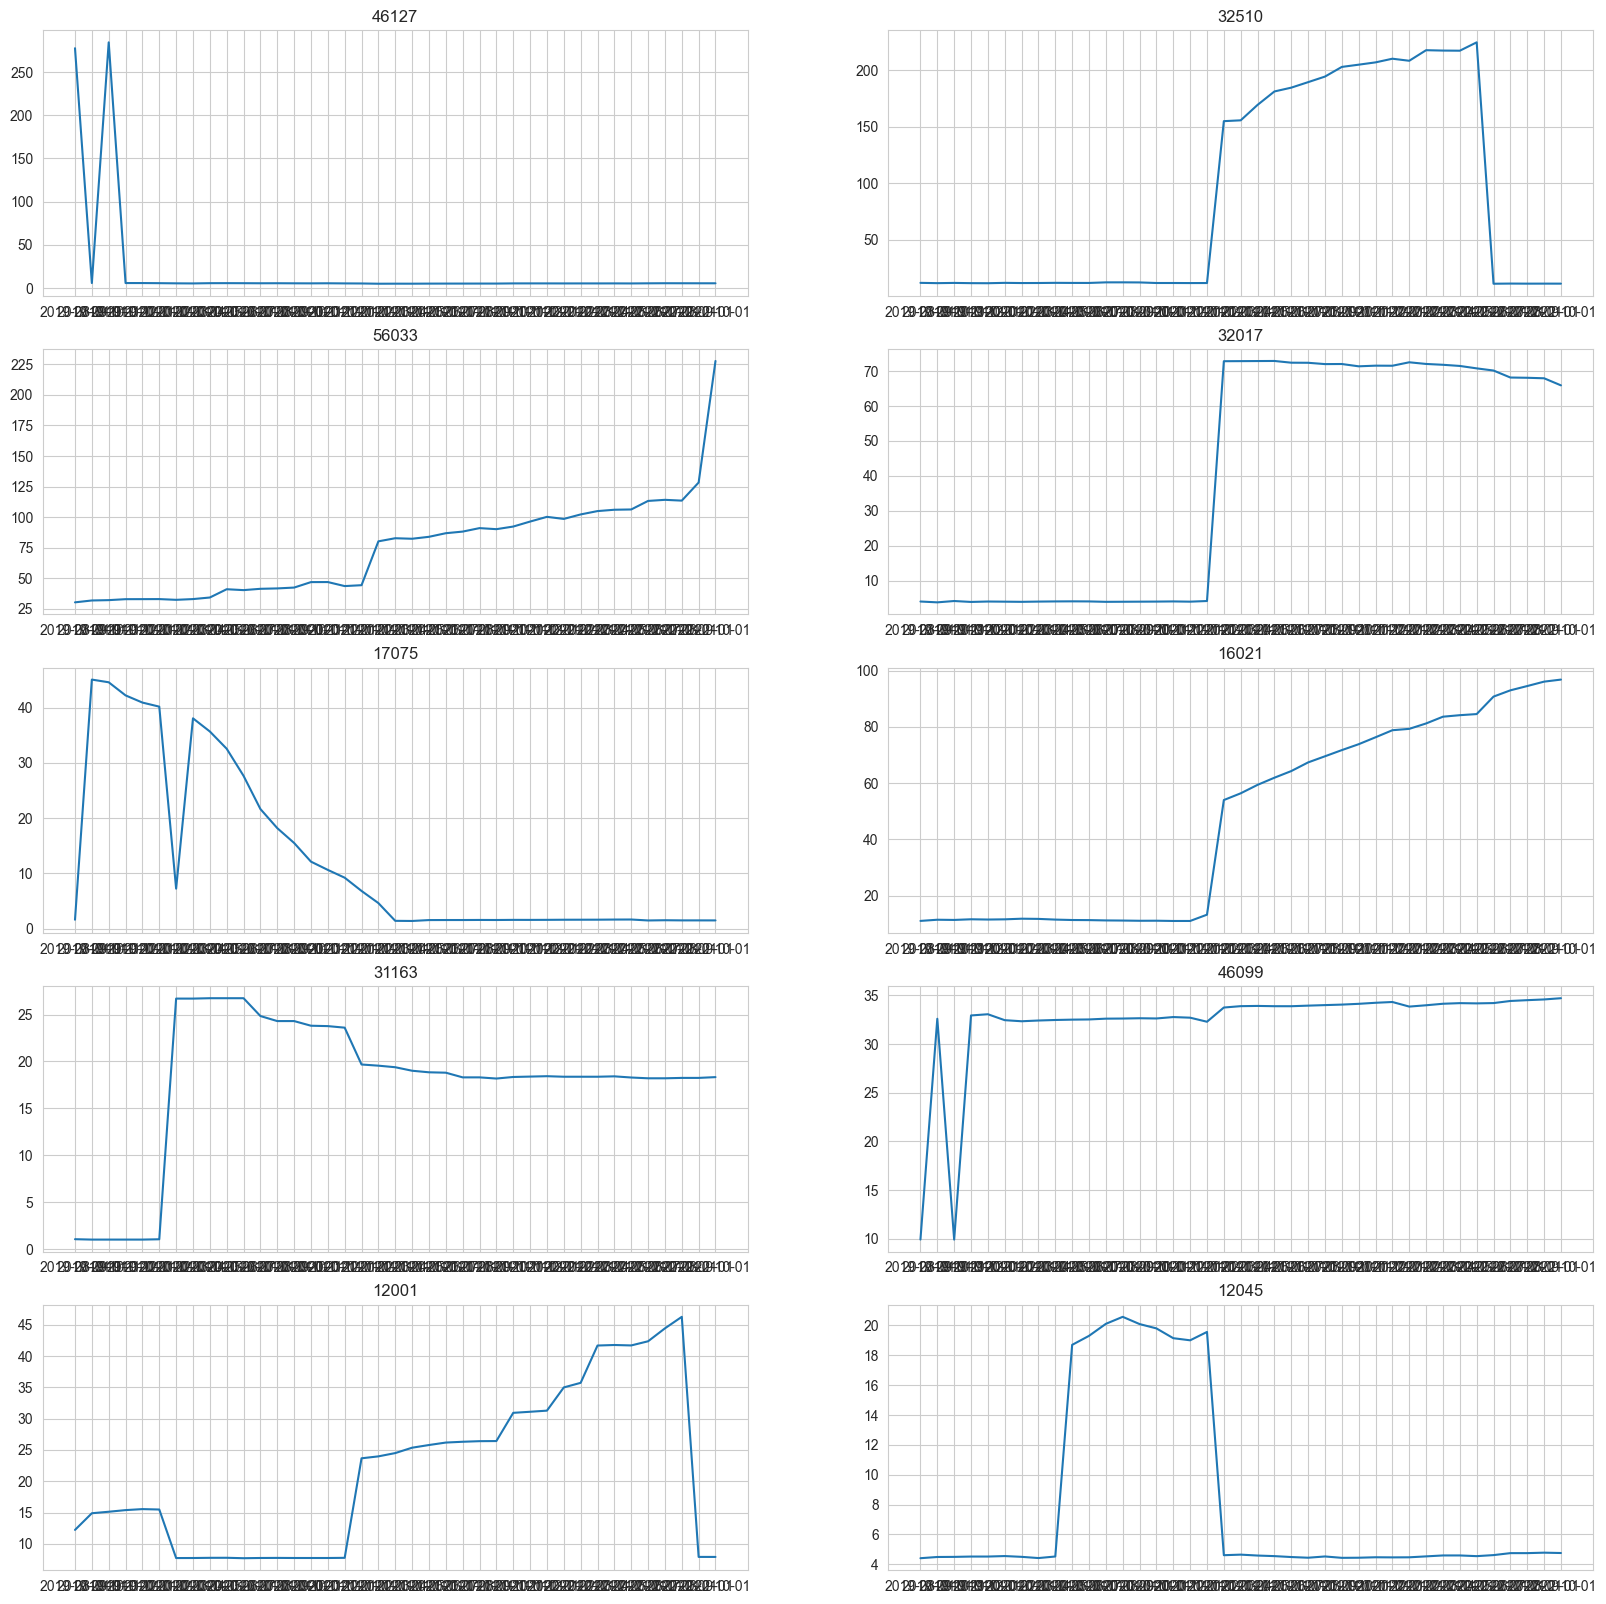

In [9]:
# Lets look at the plot for the counties with the highest rate of change
cfips_view = list(train.groupby('cfips')['rate_of_change'].max().sort_values(ascending=False).head(10).index)

sns.set_style('whitegrid')


fig, ax = plt.subplots(5, 2, figsize=(20, 20))

for county, ax in zip(cfips_view, ax.flatten()):
    temp = train[train['cfips'] == county]
    ax.plot(temp['first_day_of_month'], temp['microbusiness_density'])
    ax.set_title(county)

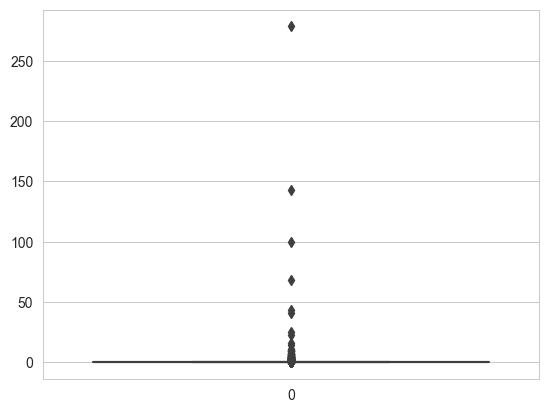

In [10]:
# Lets look at a boxplot for max rate of change

values = train.groupby('cfips')['rate_of_change'].max().values

fig = sns.boxplot(values)

In [11]:
# Lets look at the distribution of the max rate of change

print(np.percentile(values, 95))

# get all the values above the 95th percentile

percentile = [x for x in values if x > np.percentile(values, 95)]

# Is this significant?, lets run a t-test taking the 95th percentile and the mean of the max rate of change

import scipy.stats as stats

t_stat, p_val = stats.ttest_1samp(percentile, np.mean(values))
print("t-statistic:", t_stat)
print("p-value:", p_val)

# This can be interpreted as the p-value is less than 0.05, so we can reject the null hypothesis that the mean of the max rate of change is equal to the 95th percentile

1.20101146
t-statistic: 3.2961584584671995
p-value: 0.001213549291567336


In [12]:
# Lets take an in-depth look at these anomalies and see if we can find a pattern

train[train['cfips'] == 32510]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,rate_of_change
68640,32510_2019-08-01,32510,Carson City,Nevada,2019-08-01,11.617217,5004,0.000000
68641,32510_2019-09-01,32510,Carson City,Nevada,2019-09-01,11.357200,4892,-0.260017
68642,32510_2019-10-01,32510,Carson City,Nevada,2019-10-01,11.563821,4981,0.206621
68643,32510_2019-11-01,32510,Carson City,Nevada,2019-11-01,11.352556,4890,-0.211265
68644,32510_2019-12-01,32510,Carson City,Nevada,2019-12-01,11.296838,4866,-0.055718
68645,32510_2020-01-01,32510,Carson City,Nevada,2020-01-01,11.617307,5021,0.320469
68646,32510_2020-02-01,32510,Carson City,Nevada,2020-02-01,11.450717,4949,-0.166590
68647,32510_2020-03-01,32510,Carson City,Nevada,2020-03-01,11.485423,4964,0.034706
68648,32510_2020-04-01,32510,Carson City,Nevada,2020-04-01,11.628876,5026,0.143453
68649,32510_2020-05-01,32510,Carson City,Nevada,2020-05-01,11.557150,4995,-0.071726


C:\Users\commo\AppData\Local\Temp\ipykernel_3772\3864783170.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticklabels(), color="white")


[Text(0, 0.0, '0'),
 Text(0, 25.0, '25'),
 Text(0, 50.0, '50'),
 Text(0, 75.0, '75'),
 Text(0, 100.0, '100'),
 Text(0, 125.0, '125'),
 Text(0, 150.0, '150'),
 Text(0, 175.0, '175'),
 Text(0, 200.0, '200'),
 Text(0, 225.0, '225')]

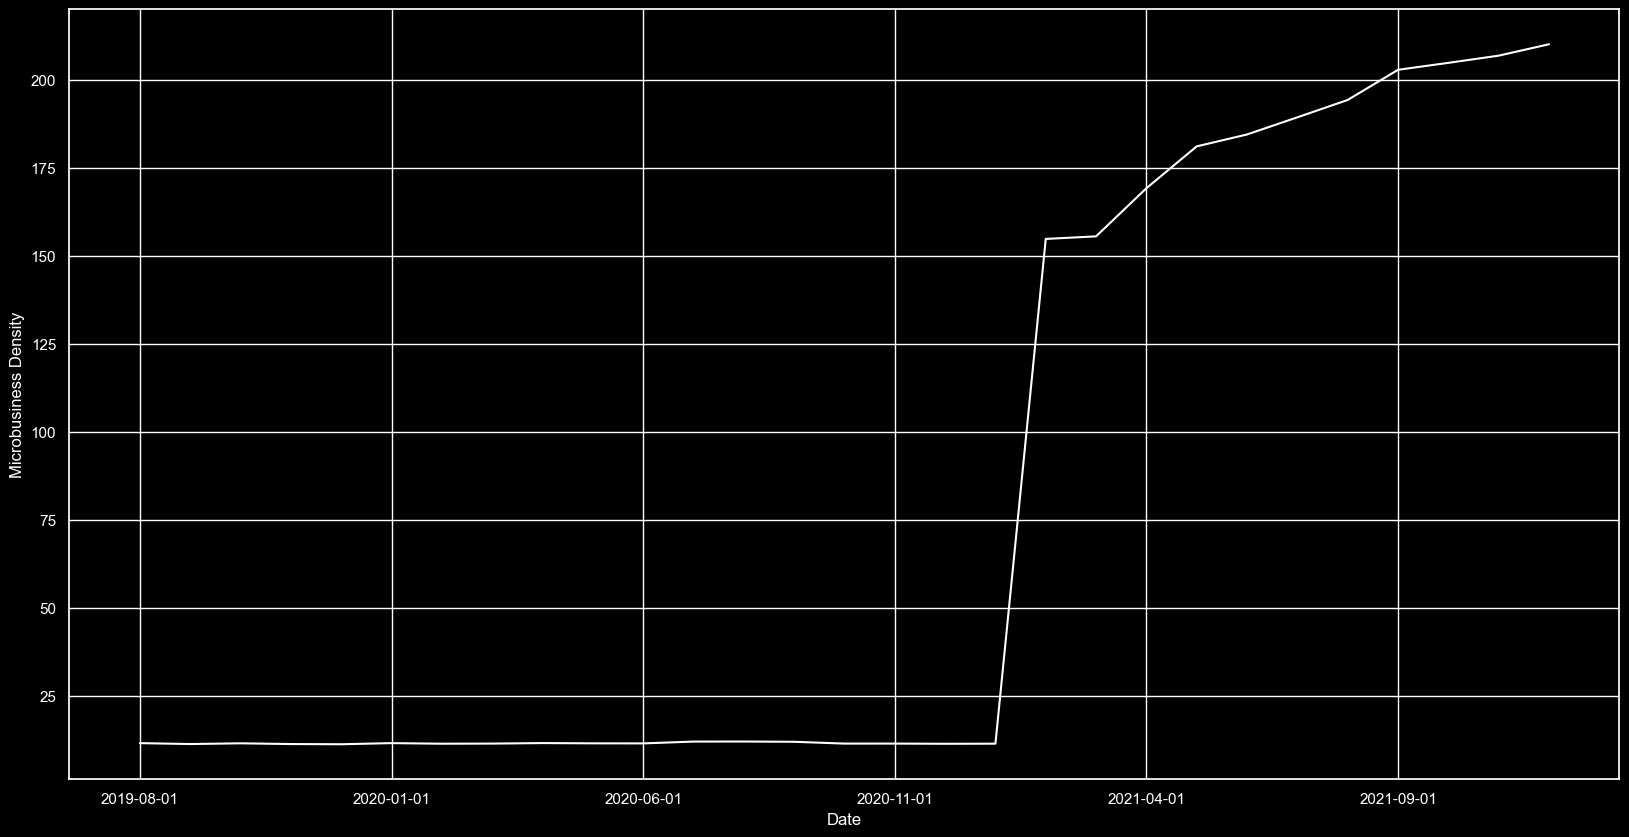

In [56]:
# making a graph for slide deck

fig = train[train['cfips'] == 32510].plot(x='first_day_of_month', y='microbusiness_density', figsize=(20, 10), color='white', legend = None)
fig.set_xlabel('Date', color = 'white')
fig.set_ylabel('Microbusiness Density', color = 'white')
fig.set_xticklabels(fig.get_xticklabels(), color="white")
fig.set_yticklabels(fig.get_yticklabels(), color="white")


In [14]:
# Lets look for counties that have experienced a decrease in microbusiness density
cfips_negative = []
negative_values = []

for county in train['cfips'].unique():
    temp = train[train['cfips'] == county]['rate_of_change'].sum()
    if temp <= 0:
        cfips_negative.append(county)
        negative_values.append(temp)
    
print('There are {} counties that have experienced a decrease in microbusiness density'.format(len(cfips_negative)))

There are 1122 counties that have experienced a decrease in microbusiness density


In [15]:
for county, value in zip(cfips_negative, negative_values):
    if value < -1:
        print('County: {} has a total rate of change of {}'.format(county, value))

County: 1125 has a total rate of change of -1.7732325000000007
County: 2060 has a total rate of change of -10.942060999999999
County: 5055 has a total rate of change of -13.959204600000001
County: 5141 has a total rate of change of -7.215512699999999
County: 6051 has a total rate of change of -1.3176506000000003
County: 6075 has a total rate of change of -1.461192999999998
County: 6085 has a total rate of change of -1.1008940000000003
County: 6115 has a total rate of change of -4.3636953
County: 8007 has a total rate of change of -1.7249989999999986
County: 8013 has a total rate of change of -1.0100540000000002
County: 8014 has a total rate of change of -1.9183100000000017
County: 8015 has a total rate of change of -1.1979778000000003
County: 8035 has a total rate of change of -1.5891380000000002
County: 8061 has a total rate of change of -1.1670460999999994
County: 8069 has a total rate of change of -1.2608067000000016
County: 8093 has a total rate of change of -2.3448075999999993
Cou

### Next Steps

* Look at the variability in microbusinesses in counties of small population

* Look at the rate of change given specific regions and states

* Look at different features that may help determine microbusiness density





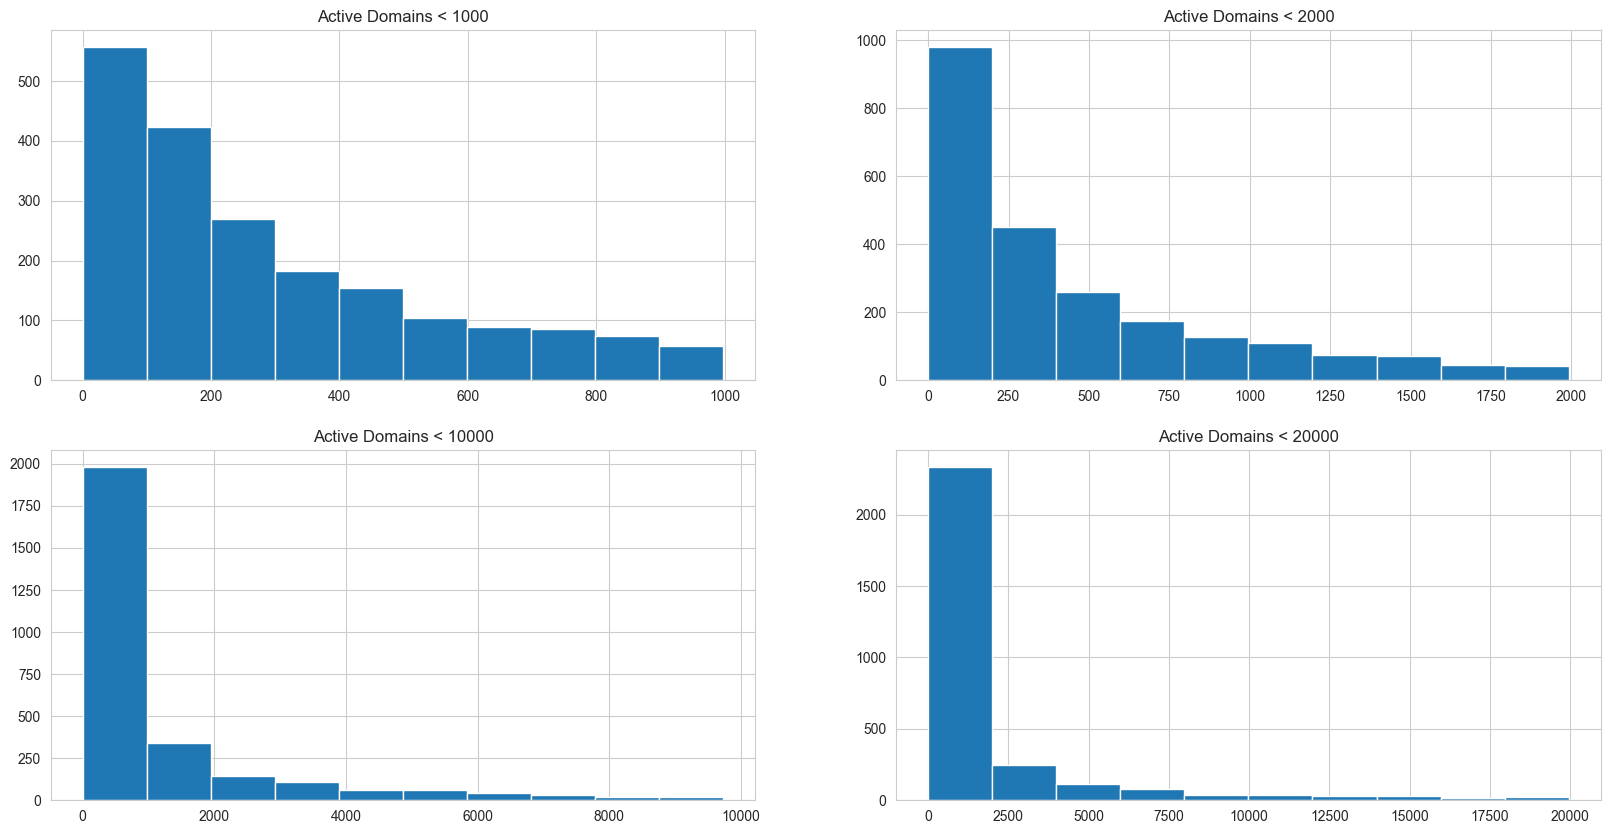

In [16]:
# Check the distribution of active domains for all counties, cut into 10 bins

active = train.groupby('cfips')['active'].median().sort_values(ascending=False)

fig, ax = plt.subplots(2,2, figsize=(20, 10))
thresholds = [ 1000, 2000, 10000, 20000]

for threshold, ax in zip(thresholds, ax.flatten()):
    temp = active[active < threshold]
    ax.hist(temp, bins=10)
    ax.set_title('Active Domains < {}'.format(threshold))

### Distribution:

Because it counts data, it is likely to follow the Poisson distribution, so I chose less than 2000 as a reasonable heuristic after checking the distribution for other values.

Another insight in viewing variability is that it may not generate any insight about variability because there is no way to distinguish if active domains can help filter out population size without accessing population information.

So I decided to calculate the population size based on the population size, a simple equation.

population = (active domains/microbusiness density) * 100

In [17]:
# Lets calculate the population size for each county and row

train['population_size'] = train['active'] / train['microbusiness_density'] * 100

In [18]:
# Lets check the distribution of population size for all counties, cut into 10 bins

train.groupby('cfips')['population_size'].mean().describe()

count    3.135000e+03
mean     7.995394e+04
std      2.555802e+05
min      7.873529e+01
25%      8.473321e+03
50%      2.019859e+04
75%      5.277727e+04
max      7.856462e+06
Name: population_size, dtype: float64

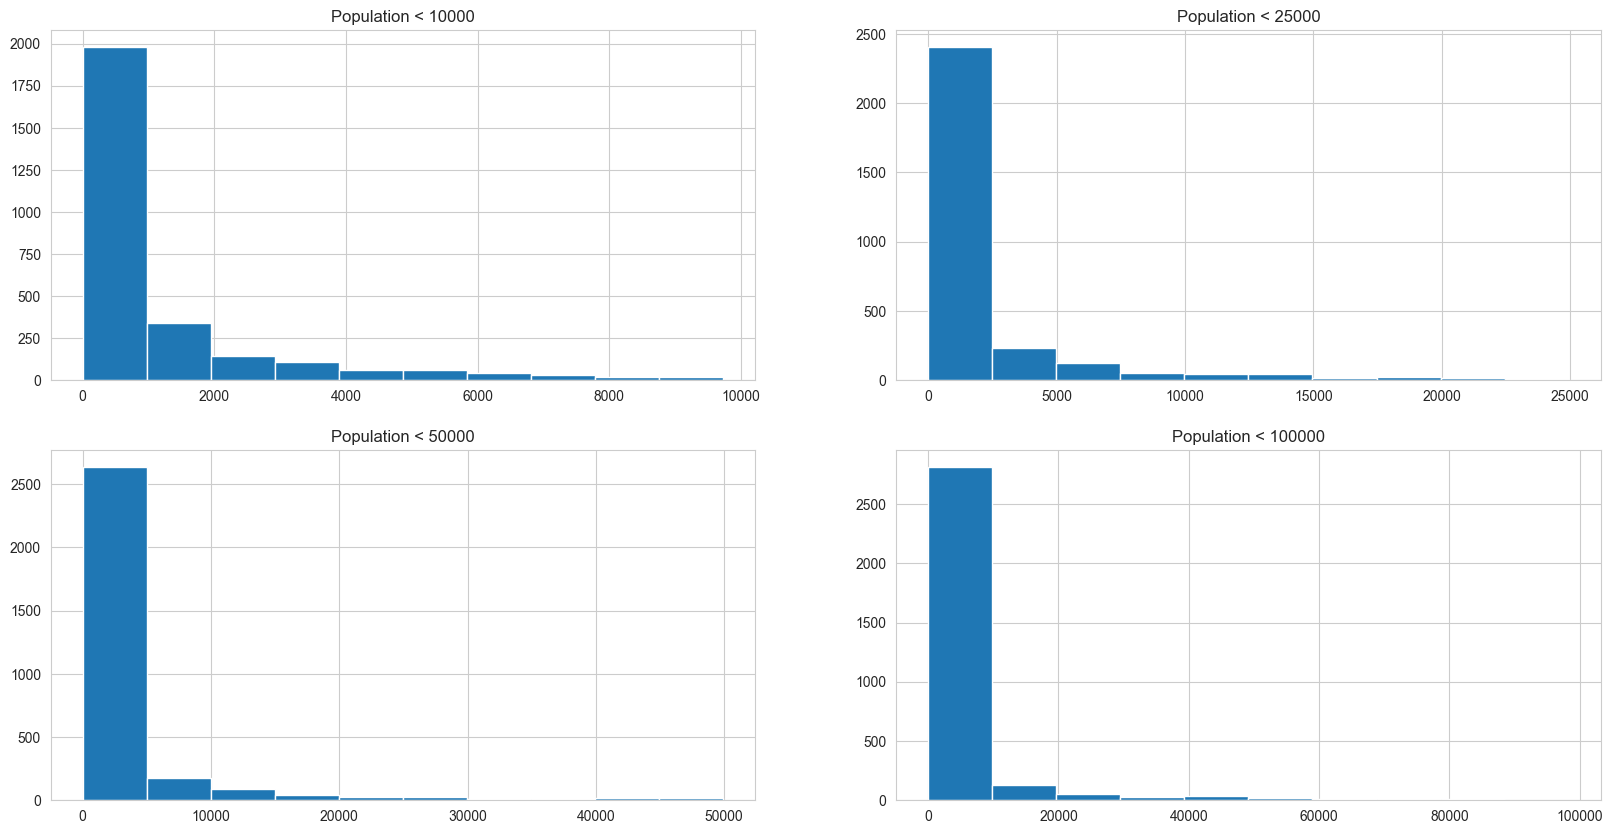

In [19]:
# Check the size of population given certain thresholds

population = train.groupby('cfips')['population_size'].mean()

fig, ax = plt.subplots(2,2, figsize=(20, 10))
thresholds = [10000, 25000, 50000, 100000]

for threshold, ax in zip(thresholds, ax.flatten()):
    temp = active[active < threshold]
    ax.hist(temp, bins=10)
    ax.set_title('Population < {}'.format(threshold))

In [20]:
train[train['population_size'] < 50000].groupby('cfips')['microbusiness_density'].std().sort_values(ascending=False).describe()

count    2324.000000
mean        0.384926
std         2.785987
min         0.012630
25%         0.074990
50%         0.125793
75%         0.230193
max        93.048603
Name: microbusiness_density, dtype: float64

In [21]:
train[train['population_size'] > 50000].groupby('cfips')['microbusiness_density'].std().sort_values(ascending=False).describe()

count    827.000000
mean       0.309814
std        0.874123
min        0.023210
25%        0.094823
50%        0.158569
75%        0.278005
max       17.373696
Name: microbusiness_density, dtype: float64

In [22]:
train.groupby('cfips')['population_size'].max().sort_values(ascending=False).astype('int64').head(10)

cfips
6037     7866810
17031    4064766
48201    3431658
4013     3361761
6073     2605720
6059     2472630
12086    2160999
36047    2026305
48113    1936816
36081    1865585
Name: population_size, dtype: int64

### Region Features:

cfips - fips codes are abbreviated by the starting two numbers by state

https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm



In [23]:
# Check rate of change for counties by state 

train.groupby('state')['rate_of_change'].median().sort_values(ascending=False).describe()

count    51.000000
mean      0.004837
std       0.017767
min       0.000000
25%       0.000000
50%       0.000000
75%       0.002717
max       0.118436
Name: rate_of_change, dtype: float64

In [24]:
# Had to do some pre-processing for ArcGis

microbusinesses_state = train.groupby('state')['microbusiness_density'].mean().sort_values(ascending=False).reset_index()

microbusinesses_county = train.groupby('cfips')['microbusiness_density'].mean().sort_values(ascending=False).reset_index()

In [25]:
# Edit cfips to match the format of the ArcGis data by adding a 0 to the front of the cfips if less than 4 digits

microbusinesses_county = microbusinesses_county.astype('str')

microbusinesses_county['cfips'] = microbusinesses_county['cfips'].apply(lambda x: x.zfill(5))

microbusinesses_county.head()

,cfips,microbusiness_density
0,32510,87.19662461538462
1,56033,73.51041048717948
2,08105,60.942899346153844
3,41061,54.52295835897436
4,16021,46.730638


In [26]:
# Decided to export data into a csv file to use in ArcGIS for mapping and cartogram for visualization

microbusinesses_state.to_csv('state_join.csv', index=False)

microbusinesses_county.to_csv('county_join.csv', index=False)

In [27]:
train['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [28]:
# Bar graph of microbusiness density by region, first we need to set a mapping

regions = {'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'],
           'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'],
            'West': ['Montana', 'Idaho', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii'],
            'North': ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio']}

for key, value in regions.items():
    train.loc[train['state'].isin(value), 'region'] = key

train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,rate_of_change,population_size,region
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0.000000,41526.999299,South
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,-0.122812,41526.999777,South
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0.170973,41527.001174,South
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,-0.062610,41527.001638,South
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0.000000,41527.001638,South


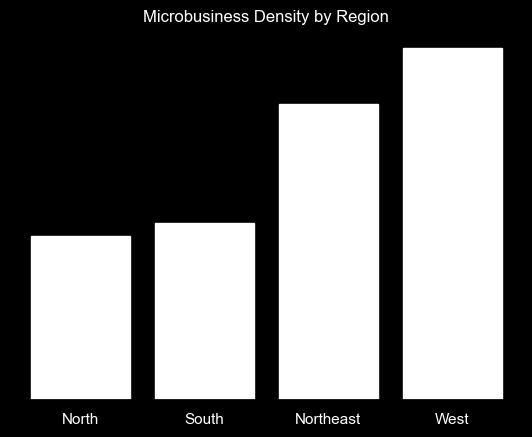

In [29]:
# take the mean of each state then group by region // made for visualization, not used in analysis, 
# analysis would rqeuire removing domain investors and then collapsing the time for each county

sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})

region = train.groupby('region')['microbusiness_density'].mean().sort_values(ascending=True)

plt = sns.barplot(x=region.index, y=region.values)

# change the background to black, bars to white, and text to white

plt.set_facecolor('black')

for patch in plt.patches:
    patch.set_facecolor('white')
    
plt.set_xlabel('', color='white')
plt.set_ylabel('', color='white')
plt.set_title('Microbusiness Density by Region', color='white')
plt.set_yticklabels('', color='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='both', color='black', bottom=True, top=True, left=True, right=True)

plt.spines['bottom'].set_color('black')
plt.spines['top'].set_color('black')
plt.spines['left'].set_color('black')
plt.spines['right'].set_color('black')

plt.grid(color='black', linestyle='-', linewidth=0.5)


### Population Features:



In [30]:
# Lets check current population survey to see if there is a way to map the county to the population

population.head()

cfips
1001     42068.384628
1003    165463.205696
1005     20160.897057
1007     17844.102651
1009     44255.589909
Name: population_size, dtype: float64

--------------
I can not find any documentation for these variables, so I will save this data to explore for later

### Census Features:

cfips = county identifier

pct_bb_(year) = percentage of households in the country with access to broadband

pct_college_(year) = percentage of population over age 25 with 4-year degree

pct_foreign_country_(year) = percentage of population born outside of the usa

pct_it_workers_(year) = percentage of workforce employed in it industrys

median_hh_inc_(year) = median household income in the county



In [31]:
# read in census

census = pd.read_csv('census_starter.csv')

In [32]:
# Look at census and see if there is a way to map counties to states

census.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [33]:
census.index

RangeIndex(start=0, stop=3142, step=1)

In [34]:
census.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

In [35]:
len(train.cfips.unique())

3135

In [36]:
census = census.set_index('cfips')

In [37]:
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [38]:
# prepare the data to be merged

metrics2017 = census[['pct_bb_2017','pct_college_2017','pct_it_workers_2017','median_hh_inc_2017']]
metrics2017['year'] = 2017
metrics2017.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','year']

metrics2018 = census[['pct_bb_2018','pct_college_2018','pct_it_workers_2018','median_hh_inc_2018']]
metrics2018['year'] = 2018
metrics2018.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','year']

metrics2019 = census[['pct_bb_2019','pct_college_2019','pct_it_workers_2019','median_hh_inc_2019']]
metrics2019['year'] = 2019
metrics2019.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','year']

metrics2020 = census[['pct_bb_2020','pct_college_2020','pct_it_workers_2020','median_hh_inc_2020']]
metrics2020['year'] = 2020
metrics2020.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','year']

metrics2021 = census[['pct_bb_2021','pct_college_2021','pct_it_workers_2021','median_hh_inc_2021']]
metrics2021['year'] = 2021
metrics2021.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','year']

C:\Users\commo\AppData\Local\Temp\ipykernel_3772\3779463282.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics2017['year'] = 2017
C:\Users\commo\AppData\Local\Temp\ipykernel_3772\3779463282.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics2018['year'] = 2018
C:\Users\commo\AppData\Local\Temp\ipykernel_3772\3779463282.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [39]:
# reset the index to be able to merge 

merge2017 = metrics2017.reset_index()
merge2018 = metrics2018.reset_index()
merge2019 = metrics2019.reset_index()
merge2020 = metrics2020.reset_index()
merge2021 = metrics2021.reset_index()

In [40]:
# stack the data on year 

merge = pd.concat([merge2017, merge2018, merge2019, merge2020, merge2021])


In [41]:
merge = merge.iloc[:,:6]

merge.columns = ['cfips', 'pct_bb', 'pct_college', 'pct_it_workers', 'median_hh_inc', 'year']

In [42]:
merge.isna().sum()

cfips             0
pct_bb            2
pct_college       2
pct_it_workers    3
median_hh_inc     5
year              0
dtype: int64

In [43]:
merge = merge.fillna(0)

In [44]:
# create a year column to merge the data in train

train['date'] = pd.to_datetime(train['first_day_of_month'])

train['year'] = train['date'].dt.year

In [45]:
# merge the data on cfips and year

train = train.merge(merge, on=['cfips', 'year'])

train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,rate_of_change,population_size,region,date,year,pct_bb,pct_college,pct_it_workers,median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0.000000,41526.999299,South,2019-08-01,2019,80.6,16.1,0.7,58731.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,-0.122812,41526.999777,South,2019-09-01,2019,80.6,16.1,0.7,58731.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0.170973,41527.001174,South,2019-10-01,2019,80.6,16.1,0.7,58731.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,-0.062610,41527.001638,South,2019-11-01,2019,80.6,16.1,0.7,58731.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0.000000,41527.001638,South,2019-12-01,2019,80.6,16.1,0.7,58731.0


------ 
Something went wrong here with the merging of dataframes which will have to be fixed later.

In [46]:
train.isna().sum()

# success! now we can continue with the analysis

row_id                    0
cfips                     0
county                    0
state                     0
first_day_of_month        0
microbusiness_density     0
active                    0
rate_of_change            0
population_size          16
region                    0
date                      0
year                      0
pct_bb                    0
pct_college               0
pct_it_workers            0
median_hh_inc             0
dtype: int64

In [47]:
# get the rows where median_hh_inc is null

train[train['median_hh_inc'].isna()]

# counties with low population size, so we can fillna 0 for now

train['median_hh_inc'] = train['median_hh_inc'].fillna(0)

In [48]:
# get the rows where population siez is null

train[train['population_size'].isna()]

# the place is called issaquena county and is a small county in mississippi but we can fill in with the google search for size

train['population_size'] = train['population_size'].fillna(0)

In [49]:
train.isna().sum()

# Now we can start to analyze the census data

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
rate_of_change           0
population_size          0
region                   0
date                     0
year                     0
pct_bb                   0
pct_college              0
pct_it_workers           0
median_hh_inc            0
dtype: int64

### Correlated Features:

All of the census information are weakly correlated with the active amount of microbusiness.

What is important to note here is that since, population size was calculated it will be correlated with the variable it was calculated.

What needs to be done here is to find the non-time lagged population size and calculate the correlation between the population.

[Text(0, 0.5, 'active'),
 Text(0, 1.5, 'pct_college'),
 Text(0, 2.5, 'pct_it_workers'),
 Text(0, 3.5, 'median_hh_inc'),
 Text(0, 4.5, 'population_size')]

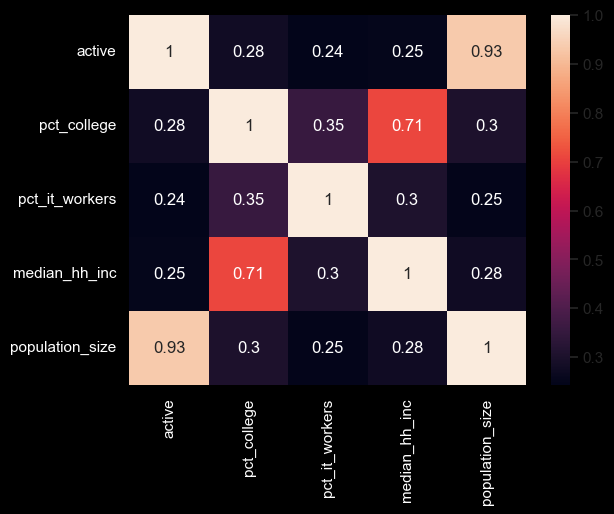

In [50]:
# lets start by looking at a heatmap for the correlation between the census features

fig = sns.heatmap(train[['active', 'pct_college', 'pct_it_workers', 'median_hh_inc', 'population_size',]].corr(), annot=True)

# set the annotation labels to white

fig.set_xticklabels(fig.get_xticklabels(), color="white")
fig.set_yticklabels(fig.get_yticklabels(), color="white")

In [51]:
# I found data for the 2021 census that has the population size for each county, so the correlation can be checked for a year

census2021 = pd.read_excel('wa.xlsx', sheet_name='wa', usecols='A,B,C')

In [52]:
# lets check for any preprocessing 

census2021.head()

,GEO_ID,NAME,S0101_C01_001E
0,Geography,Geographic Area Name,Estimate!!Total!!Total population
1,0500000US01003,"Baldwin County, Alabama",239294
2,0500000US01015,"Calhoun County, Alabama",115972
3,0500000US01043,"Cullman County, Alabama",89496
4,0500000US01049,"DeKalb County, Alabama",71813


In [53]:
# skip the first row

census2021 = census2021.iloc[1:,:]

# geo id is the cfips code but we need to remove the leading bits and then remove leading zeros

census2021['GEO_ID'] = census2021['GEO_ID'].str.replace('0500000US', '')

census2021['GEO_ID'] = census2021['GEO_ID'].astype(int)

# name can be dropped and the column can be renamed

census2021 = census2021.drop('NAME', axis=1)

census2021.columns = ['cfips', 'population_size_unlagged']

census2021.head()

,cfips,population_size_unlagged
1,1003,239294
2,1015,115972
3,1043,89496
4,1049,71813
5,1051,89304


In [54]:
# get the rows where year is 2021 then merge

train2021 = train[train['year'] == 2021]

train2021 = train2021.merge(census2021, on='cfips')

## Pre-Processing / Feature Engineering

Possible Transformations:

1. RobustScaler/StandardScaler because linear regression operates on the assumption of normality and the transformation will help the model learn the distribution.


Potential Features:

* Key Note: Lagged features could be used to improve performance

* Region: Specific regions may have more interest in microbusineses than others, an expanding window for mean rate-of-change could be used to target encode variables

* Broadband Access: Having internet likely correlates with domain registration, naive estimate for test feature vector or data from government can be used to estimate 2022 - 2023

* States: Specific states may have more interest in microbusines than others, same as regions

* Median Income: Having more income could allow quick microbussiness start-ups, naive estimate for test feature vector or data from government can be used to estimate 2022 - 2023

* Lagged Microbusiness Activity: Checking for autocorrelation between different time states to determine whether past data is related to future data



Possible Methods in Addressing Domain Investors:

1. For counties that consistenly have a high rate of change just take the last value for future predictions

2. For county that had only one instance of high rate of change, take the median, with the idea that GoDaddy will eventually correct the outliers within private lb

3. Create a heuristic slope line that regresses towards the mean value before the high rate of change






C:\Users\commo\AppData\Local\Temp\ipykernel_27100\205880794.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_yticklabels(yticklabels, color='white')
C:\Users\commo\AppData\Local\Temp\ipykernel_27100\205880794.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(xticklabels, color='white')


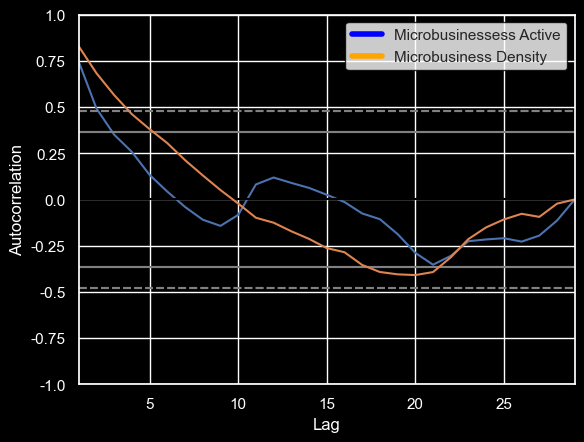

In [ ]:
# Graph for lagged microbusiness density autocorrelation

from pandas.plotting import autocorrelation_plot
from matplotlib.lines import Line2D


plt = autocorrelation_plot(train.groupby('first_day_of_month')['active'].mean())
autocorrelation_plot(train.groupby('first_day_of_month')['microbusiness_density'].mean())


custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4)]

# Change the y_axis labels to white

plt.set_ylabel('Autocorrelation', color='white')
plt.set_xlabel('Lag', color='white')
yticklabels = np.linspace(-1, 1, 9).round(2)
xticklabels = np.linspace(0, 40, 9).astype('int64')
plt.set_yticklabels(yticklabels, color='white')
plt.set_xticklabels(xticklabels, color='white')

plt.legend(custom_lines, ['Microbusinessess Active', 'Microbusiness Density'], loc='upper right', facecolor='white', edgecolor='black')

### Lagged Activity 

In [ ]:
test = pd.read_csv('test.csv')
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [ ]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


### Creative Ideas:

1. Instead of creating predictions for microbusiness density as target variables, predict the active domains a county will have and then calculate the microbusiness density using a recent census. My intuition is that predicting a ratio, that is calculated by two variables, active sites & population, is incorrect because GoDaddy computed the ratio with a known population already. This meant that if you already have information on the population, you can use the population to calculate the ratio and only need to predict the active sites in the future.

Example: January 2023 will have active domains forecast divided by a 2-year time lag population in January 2021 to get predicted microbusiness density.

2. During validation, calculate the error between predictions and find the counties that have large errors and implement a heuristic for them instead / do EDA analysis on why the errors are high.

3. Some lagged features may be okay because features like broadband access could have their effects lagged as well




### How My Approach Differs From Public Notebooks:

1. Linear Parameters: Other approaches high on the leaderboard utilize XGBregressors which assume non-linearity in the models, which can be seen as over-fitting and generating large error rates that have to be manually corrected using last value heuristics. My approach aims to find the correct feature variables that are linearly correlated with active sites in order to calculate the correct microbusiness density.

2. Domain Investor Heuristics: Most approaches take the last value of the microbusiness density when the rate of change or error is greater than a specified threshold. I have determined through my EDA that GoDaddy ends up correcting the signal from these domain investors and that given the time frame of the prediction, if GoDaddy does end up correcting, my SMAPE score would be better than the SMAPE score for the last value heuristics. 

3. Active Domain Target Variable: The target variable chosen by everyone else is the target variable of the competition, which is intended to be micro-business density. However, by reading that GoDaddy calculates their metrics using a 2-year census time-lag, utilizing accurate population surveys, I can calculate microbusiness density instead of creating a model that attempts to predict both population change and active domain change.

4. Local Validation: Instead of relying on the leaderboard to check how well my model is doing. My validation scheme is sufficient enough to determine how well my model is performing and able to generalize the results to new data. 

----------------------------------------------------------------
In general, I take more of a stakeholders-friendly approach to the data, with as much as possible focus on the interpretability of the model and the local validation scheme so that in production or practice, stakeholders know what my model represents and is doing. Although for specific areas such as deep learning, model interpretability is not capable of being determined for classification, nlp, reinforcement learning, and large-scale recommender systems. However, some interpretability can be salvaged by examining, for example, how the agent acts in rl, extracting convolutional filters in classifiers, and using bounding boxes in computer vision.


## Model

Validation Scheme: Train model on 24 months with 3-month validation and increment the 3 months until the training dataset reaches the end.

1. Group the months together and train the model then validate

Linear Model: The data is assumed to be linear time-series so the model should match data assumptions

## To-Do: 

* Implement the validation scheme by editing the code below

* Tweak heuristics for outliers 

* Finish feature engineering and model creation

----------------------------------------------------------------

I have ran out of time to finish the to-do currently, but this project will be updated later on when I have time outside of class to complete. 

This marks the end of my notebook. Thanks for reviewing my application!

C:\Users\commo\AppData\Local\Temp\ipykernel_27100\3109054225.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), color="white")
C:\Users\commo\AppData\Local\Temp\ipykernel_27100\3109054225.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticklabels(), color="white")


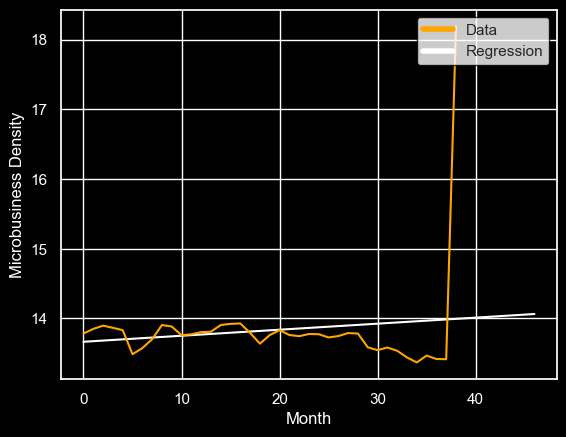

In [ ]:
# an example of fitting a regression model for slide deck
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(39,47).reshape((-1,1))

df = train[train['cfips'] == 53033]
df = df[['microbusiness_density', 'population_size', 'active']]

model = LinearRegression()
model.fit(x_train,df.microbusiness_density)

y_pred = model.predict(x_test)

x = np.arange(47).reshape(-1, 1)
y = model.predict(x)

x = np.arange(47)
df_x = np.arange(39)
fig = sns.lineplot(x=x, y=y, color='white')
sns.lineplot(x=df_x, y=df.microbusiness_density, color='orange')

fig.set_xticklabels(fig.get_xticklabels(), color="white")
fig.set_yticklabels(fig.get_yticklabels(), color="white")
fig.set_ylabel('Microbusiness Density', color='white')
fig.set_xlabel('Month', color='white')

custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='white', lw=4)]

fig.legend(custom_lines, ['Data', 'Regression'], loc='upper right', facecolor='white', edgecolor='black')

### Forecasting Insights:

While I was creating forecasts for my slide deck, I stumbled upon this cfip that had a sudden change in microbusiness, which slightly confirmed that my heuristics were in line and that during model building this would be accounted for with a custom heuristic technique, which I will provide a graph for later.

C:\Users\commo\AppData\Local\Temp\ipykernel_27100\2431254220.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), color="white")
C:\Users\commo\AppData\Local\Temp\ipykernel_27100\2431254220.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticklabels(), color="white")


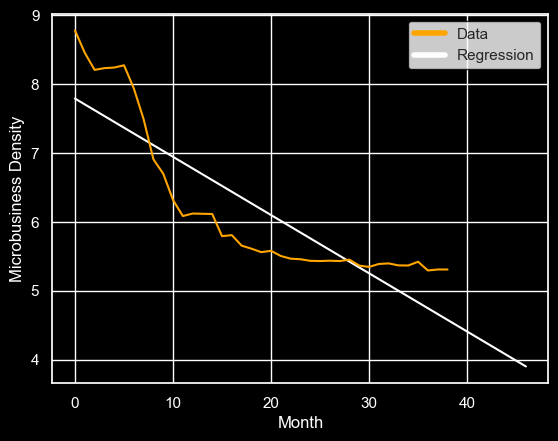

In [ ]:
# attempt number two for an example of fitting a regression model for slide deck
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(39,47).reshape((-1,1))

df = train[train['cfips'] == 53041]
df = df[['microbusiness_density', 'population_size', 'active']]

model = LinearRegression()
model.fit(x_train,df.microbusiness_density)

y_pred = model.predict(x_test)

# plot the entire forecast with the actual data

x = np.arange(47).reshape(-1, 1)
y = model.predict(x)

x = np.arange(47)
df_x = np.arange(39)
fig = sns.lineplot(x=x, y=y, color='white')
sns.lineplot(x=df_x, y=df.microbusiness_density, color='orange')

fig.set_xticklabels(fig.get_xticklabels(), color="white")
fig.set_yticklabels(fig.get_yticklabels(), color="white")
fig.set_xlabel('Month', color='white')
fig.set_ylabel('Microbusiness Density', color='white')

custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='white', lw=4)]

fig.legend(custom_lines, ['Data', 'Regression'], loc='upper right', facecolor='white', edgecolor='black')

<AxesSubplot: ylabel='microbusiness_density'>

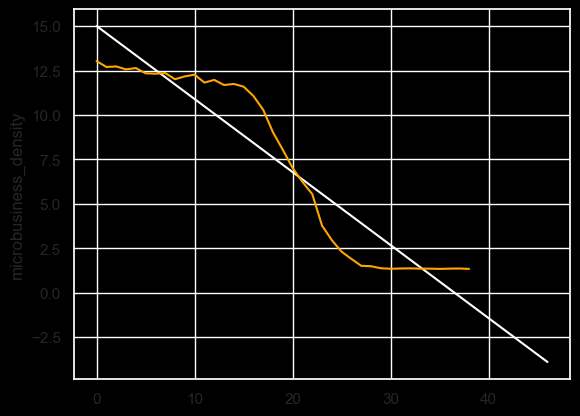

In [ ]:
# attempt number two for an example of fitting a regression model for slide deck
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(39,47).reshape((-1,1))

df = train[train['cfips'] == 51830  ]
df = df[['microbusiness_density', 'population_size', 'active']]

model = LinearRegression()
model.fit(x_train,df.microbusiness_density)

y_pred = model.predict(x_test)

# plot the entire forecast with the actual data

x = np.arange(47).reshape(-1, 1)
y = model.predict(x)

x = np.arange(47)
df_x = np.arange(39)
sns.lineplot(x=x, y=y, color='white')
sns.lineplot(x=df_x, y=df.microbusiness_density, color='orange')

18.188141
17.664623375
17.14110575
16.617588125
16.0940705
15.570552875
15.04703525
14.523517625


C:\Users\commo\AppData\Local\Temp\ipykernel_27100\4137314606.py:30: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heur_y = df.microbusiness_density.append(heur_ypred)
C:\Users\commo\AppData\Local\Temp\ipykernel_27100\4137314606.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), color="white")
C:\Users\commo\AppData\Local\Temp\ipykernel_27100\4137314606.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticklabels(), color="white")


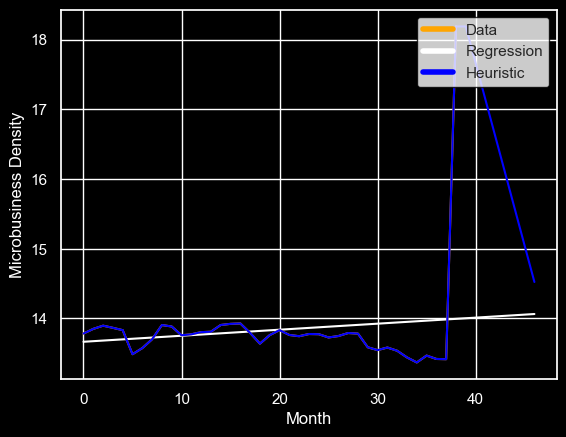

In [ ]:
# an example of fitting a regression model for slide deck
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(39,47).reshape((-1,1))

df = train[train['cfips'] == 53033]
df = df[['microbusiness_density', 'population_size', 'active']]

model = LinearRegression()
model.fit(x_train,df.microbusiness_density)

y_pred = model.predict(x_test)

x = np.arange(47).reshape(-1, 1)
y = model.predict(x)

df_x = np.arange(39)
last = df.microbusiness_density.iloc[-1] * np.ones(8)
heur_ypred = []

for value, x in enumerate(last):
    difference = (14 - last[0]) / 8
    value = value * difference + df.microbusiness_density.iloc[-1]
    print(value)
    heur_ypred.append(value)
    
    
    
heur_ypred = pd.Series(heur_ypred).fillna(df.microbusiness_density.median())

heur_y = df.microbusiness_density.append(heur_ypred)

x = np.arange(47)
fig = sns.lineplot(x=x, y=y, color='white')
sns.lineplot(x=df_x, y=df.microbusiness_density, color='orange')
sns.lineplot(x=x, y=heur_y, color='blue')

fig.set_xticklabels(fig.get_xticklabels(), color="white")
fig.set_yticklabels(fig.get_yticklabels(), color="white")
fig.set_ylabel('Microbusiness Density', color='white')
fig.set_xlabel('Month', color='white')

custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='white', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

fig.legend(custom_lines, ['Data', 'Regression','Heuristic'], loc='upper right', facecolor='white', edgecolor='black')

In [ ]:
# Validation metric for the competition

def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [ ]:
# Code edited & modified from Chris Deotte's notebook

DISPLAY = 8
THRESHOLD = 0.100
ACTIVE_THRESHOLD = 50_000

# Predicting 8-months out from the last month in the training set nov 2022 - june 2023
IDS = train.cfips.unique()
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(38,47).reshape((-1,1))

preds = np.zeros((len(IDS),8))
last_preds = np.zeros((len(IDS),8))
lin_trend = 0

ct = 0
for i,c in enumerate(IDS):
    df = train.loc[train.cfips==c]
    # could try rounding to nearest 10s and taking the mode
    last = df.microbusiness_density.iloc[-1]
    population = df.population_size.values[-1]
    last_preds[i,] = [last]*8
    
    # FIT LINEAR REGRESSION
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    
    # modified heuristic to determine if time series is linear or not
    # would have implemented custom slope heuristic if I had more time
    if (population<ACTIVE_THRESHOLD)|(df['rate_of_change'].max()>1):
        preds[i,] = [last]*8
        continue
    
    # original heuristic was to calculate y-train error above a threshold

        
    # modified predicition
    p2 = model.predict(x_test)
    preds[i,] = p2[1:]
    
    # COUNT STUFF
    ct += 1
    lin_trend += 1
    if ct>=DISPLAY+1: continue
        
    
# PRINT HOW MANY LINEAR TIME SERIES WE FOUND
print(f'There are {lin_trend} counties with both a linear trend and large population.')

There are 784 counties with both a linear trend and large population.


## Submission

In [ ]:
# NOTE TEST IS SORTED BY CFIPS AND DATA. ADD PREDS TO DATAFRAME
test['microbusiness_density'] = preds.reshape((-1))
sub = test[['row_id','microbusiness_density']]
sub.to_csv('submission.csv',index=False)
print( sub.shape )
sub.head()

(25080, 2)


,row_id,microbusiness_density
0,1001_2022-11-01,3.463856
1,1001_2022-12-01,3.463856
2,1001_2023-01-01,3.463856
3,1001_2023-02-01,3.463856
4,1001_2023-03-01,3.463856
